# Model 

    1. Choose relevant columns
    2. Make dummy variables
    3. Train test split
    4. Models
        a. Multiple linear regression
        b. Lasso regression
        c. Random Forest
        d. XGBoost
        e. SVM
    5. Tune Models with GridSearchCV
    6. Test Ensembles


In [22]:
# Imports
import pandas as pd
import numpy as np

# Graphs
import matplotlib.pyplot as plt

# Train test split
from sklearn.model_selection import train_test_split

# Evaluation Metric
from sklearn.metrics import mean_absolute_error

# Models
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

# Parameters optimization
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [2]:
# Get data
df = pd.read_csv('salary_cleaned.csv')

## 1. Choose relevant columns

In [3]:
df.columns

Index(['index', 'Job Title', 'Salary Estimate', 'Job Description', 'Rating',
       'Company Name', 'Location', 'Headquarters', 'Size', 'Founded',
       'Type of ownership', 'Industry', 'Sector', 'Revenue', 'Competitors',
       'Easy Apply', 'hourly', 'min_salary', 'max_salary', 'avg_salary',
       'company_name', 'age', 'python_yn', 'rstudio_yn', 'spark_yn', 'aws_yn',
       'excel_yn', 'same_state', 'job_simple', 'seniority', 'job_state',
       'competitor_count', 'desc_len'],
      dtype='object')

In [4]:
df_model = df[['avg_salary', 'Rating', 'Size', 'Type of ownership', 'Industry', 'Sector', 'Revenue', 'competitor_count',
               'hourly','job_state', 'same_state', 'age', 'python_yn', 'spark_yn', 'aws_yn', 'excel_yn',
               'job_simple','seniority', 'desc_len', 'rstudio_yn']]

## 2. Encoding Dummies

Using pd.get_dummies()

In [5]:
df_dum = pd.get_dummies(df_model)

## 3. Train Test Split

In [9]:
X = df_dum.drop('avg_salary', axis=1)
y = df_dum.avg_salary.values

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 4. Models

### a. Linear Regression


In [11]:
lm = LinearRegression()
lm.fit(X_train, y_train)

np.mean(cross_val_score(lm, X_train, y_train, scoring='neg_mean_absolute_error', cv=3)) # -26.4489


-26.448949040904946

### b. Lasso Regression

In [12]:
# Default lasso regression
lml = Lasso()
np.mean(cross_val_score(lml, X_train, y_train, scoring='neg_mean_absolute_error', cv=3)) # -27.3398

-27.33984376285694

,alpha,error
3,0.04,-26.121232


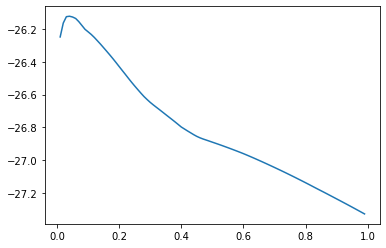

In [13]:
# Setting different alphas
alpha = []
error = []
for i in range(1,100):
    alpha.append(i/100)
    lml = Lasso(alpha=i/100)
    error.append(np.mean(cross_val_score(lml, X_train, y_train, scoring='neg_mean_absolute_error', cv=3)))
    
plt.plot(alpha, error)

err = tuple(zip(alpha, error))
df_err = pd.DataFrame(err, columns=['alpha', 'error'])
df_err[df_err.error == max(df_err.error)] # alpha = 0.04, error = -26.163

In [14]:
# Tuned Lasso regression with alpha = 0.04
lml = Lasso(alpha=0.04)
lml.fit(X_train,y_train)
np.mean(cross_val_score(lml, X_train, y_train, scoring='neg_mean_absolute_error', cv=3)) #26.1212

-26.12123246440714

Tuned Lasso regression shows a big improvement from base.

### c. Random Forest

In [15]:
np.random.seed(42)
rf = RandomForestRegressor()

np.mean(cross_val_score(rf, X_train, y_train, scoring='neg_mean_absolute_error', cv=3)) # -26.4776

-26.47762649756991

## 5. RandomizedSearchCV

In [16]:
np.random.seed(42)
# Do Random search because of running time reasons
parameters = {'n_estimators' : range(10, 300, 10),
             'criterion' : ['mae', 'mse'],
             'max_features' : ['auto', 'sqrt', 'log2']}

gs = RandomizedSearchCV(rf, parameters, scoring='neg_mean_absolute_error',cv=3)
gs.fit(X_train, y_train)

/Users/lorenzodinapoli/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/lorenzodinapoli/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/lorenzodinapoli/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/lorenzodinapoli/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Use

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(),
                   param_distributions={'criterion': ['mae', 'mse'],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'n_estimators': range(10, 300, 10)},
                   scoring='neg_mean_absolute_error')

In [17]:
gs.best_score_ # sqrt
gs.best_estimator_ # 140

RandomForestRegressor(criterion='mae', max_features='sqrt', n_estimators=140)

In [19]:
np.random.seed(42)
rf_tuned = RandomForestRegressor(criterion='sqrt', n_estimators='140')

np.mean(cross_val_score(rf, X_train, y_train, scoring='neg_mean_absolute_error', cv=3)) # -26.477

-26.47762649756991

## 6. Test Ensemble

In [20]:
tpred_lm = lm.predict(X_test)
tpred_lml = lml.predict(X_test)
tpred_rf = gs.best_estimator_.predict(X_test)

In [23]:
mean_absolute_error(y_test, tpred_lm) #25.920

25.920286595330044

In [24]:
mean_absolute_error(y_test, tpred_lml) # 25.670

25.67012861047277

In [25]:
mean_absolute_error(y_test, tpred_rf) # 25.521

25.5217509603073

In [26]:
# Combining two models
mean_absolute_error(y_test, (tpred_lm + tpred_rf)/2) # 25.2

25.20686148017739